In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

## Load the data and get basic information

In [2]:
df = pd.read_excel("data/Assignment 3 - timeseries_data.xlsx")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14987 entries, 0 to 14986
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   DATETIME                     14987 non-null  datetime64[ns]
 1   HB_NORTH (RTLMP)             14987 non-null  float64       
 2   ERCOT (WIND_RTI)             14982 non-null  float64       
 3   ERCOT (GENERATION_SOLAR_RT)  14983 non-null  float64       
 4   ERCOT (RTLOAD)               14987 non-null  float64       
 5   HOURENDING                   14987 non-null  int64         
 6   MARKETDAY                    14987 non-null  datetime64[ns]
 7   PEAKTYPE                     14987 non-null  object        
 8   MONTH                        14987 non-null  object        
 9   YEAR                         14987 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(2), object(2)
memory usage: 1.1+ MB


## Drop the unused columns and na values

In [3]:
df.drop(columns=['HOURENDING', "MARKETDAY", 'MONTH', "YEAR"], inplace=True)
df.dropna(inplace=True)
df.head()

,DATETIME,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),PEAKTYPE
0,2017-01-01 01:00:00,23.3575,2155.31,0.0,29485.791355,OFFPEAK
1,2017-01-01 02:00:00,21.4650,2313.81,0.0,28911.565913,OFFPEAK
2,2017-01-01 03:00:00,20.7350,2587.68,0.0,28238.258175,OFFPEAK
3,2017-01-01 04:00:00,20.2700,2748.65,0.0,27821.000513,OFFPEAK
4,2017-01-01 05:00:00,20.1200,2757.49,0.0,27646.942413,OFFPEAK


## Examine the data distribution

In [4]:
df.describe()

,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD)
count,14981.000000,14981.000000,14981.000000,14981.000000
mean,25.768281,7532.053149,291.997647,42372.917557
std,46.370881,3992.742693,370.929008,9874.696215
min,-17.860000,54.440000,0.000000,25566.511248
25%,18.042500,4134.730000,0.000000,35432.588663
50%,20.057500,7281.370000,22.150000,39935.131628
75%,25.030000,10851.640000,608.660000,47871.380668
max,2809.357500,20350.400000,1257.540000,73264.662123


Text(0.5, 1.0, 'RTLOAD')

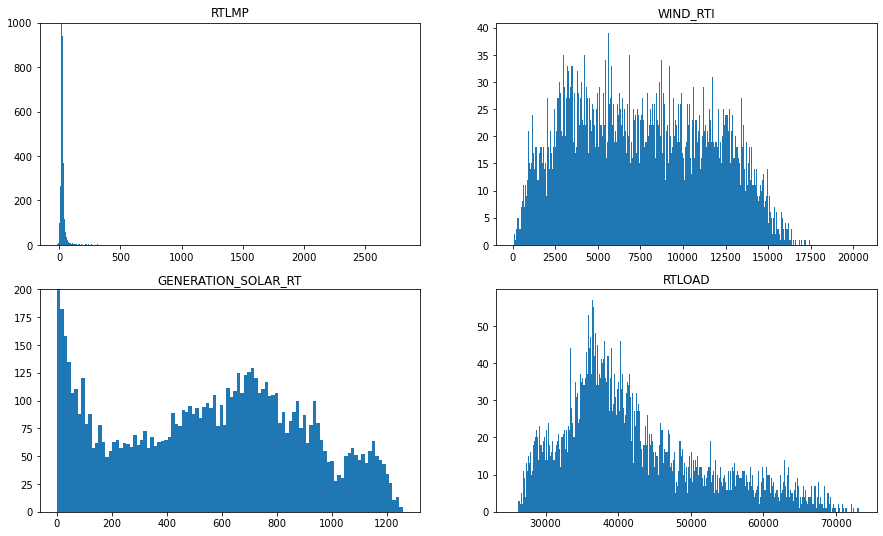

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(15, 9))
ax = ax.flatten()
ax[0].hist(df["HB_NORTH (RTLMP)"], bins=1000)
ax[0].set_ylim(0, 1000)
ax[0].set_title("RTLMP")

ax[1].hist(df["ERCOT (WIND_RTI)"], bins=1000)
ax[1].set_title("WIND_RTI")

ax[2].hist(df["ERCOT (GENERATION_SOLAR_RT)"], bins=100)
ax[2].set_ylim(0, 200)
ax[2].set_title("GENERATION_SOLAR_RT")

ax[3].hist(df["ERCOT (RTLOAD)"], bins=1000)
ax[3].set_title("RTLOAD")

### Summarise of the distribution

- RTLMP: The value has a high variance and many outliers, we need to remove these outliers before fitting.
- WIND_RTI: This value is symmetric, which suggest we can use the normal distribution to approimate the data.
- GENERATION_SOLAR_RT: Over 1/4 of the value is zero, and the data has a distribution of two peaks. And it has much smaller value than WIND_RTI, which suggest we can binerize the data by some threshold.
- RTLOAD: The value is larger than zero and has a long tail. We can use gamma distribution to approximate the data.

### Remove the outliers for RTLMP

We remove the data by moving the datapoint that is away from the mean 3 standard deviations. We do this for three times since the data is highly skewed.

In [6]:
for i in range(3):
    df = df[
        (df["HB_NORTH (RTLMP)"].mean() - 3 * df["HB_NORTH (RTLMP)"].std() <= df["HB_NORTH (RTLMP)"]) 
            & (df["HB_NORTH (RTLMP)"] <= df["HB_NORTH (RTLMP)"].mean() + 3 * df["HB_NORTH (RTLMP)"].std())
    ]

Text(0.5, 1.0, 'RTLMP')

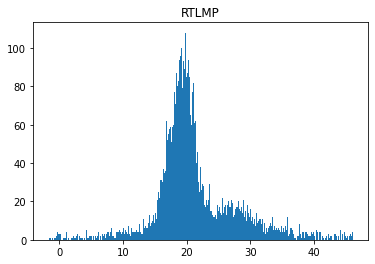

In [7]:
plt.hist(df["HB_NORTH (RTLMP)"], bins=1000)
plt.title("RTLMP")

## Predict the RTLMP

The predicting variables are

- RTLOAD
- WIND_RTI
- PEAKTYPE (category)
- GENERATION_SOLAR_RT (discritized)
- MONTH (category)
- HOUR (category)


In [8]:
solar = (df["ERCOT (GENERATION_SOLAR_RT)"] < 200).map({True: "SOLAR", False: "NO_SOLAR"})

hours = df["DATETIME"].dt.hour.astype(str)
hours.name = "hour"
monthes = df["DATETIME"].apply(lambda x: x.strftime("%B"))
monthes.name = "month"

X = pd.concat([pd.get_dummies(monthes), pd.get_dummies(hours), pd.get_dummies(solar), df[["ERCOT (RTLOAD)", "ERCOT (WIND_RTI)"]], pd.get_dummies(df["PEAKTYPE"])], axis=1)
Y = df["HB_NORTH (RTLMP)"]

np.random.seed(0)
train_index = np.random.choice(X.index, int(len(X) * 0.8), replace=False)
X_train = X.loc[train_index]
Y_train = Y.loc[train_index]
X_test = X.drop(train_index)
Y_test = Y.drop(train_index)

In [9]:
lr = sm.OLS(Y_train, X_train)
res = lr.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       HB_NORTH (RTLMP)   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     719.7
Date:                Mon, 23 May 2022   Prob (F-statistic):               0.00
Time:                        21:26:18   Log-Likelihood:                -30936.
No. Observations:               11439   AIC:                         6.195e+04
Df Residuals:                   11400   BIC:                         6.224e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
April                3.2605      0.109     29.925      0.000       3.047       3.474
August              -2.6351      0.135    -19.552      0.000      -2.899      -2.371
December            -1.1951      0.144     -8.327      0.000      -1.476      -0.914
February             1.3556      0.109     12.402      0.000       1.141       1.570
January              2.3166      0.107     21.563      0.000       2.106       2.527
July                -2.6609      0.141    -18.811      0.000      -2.938      -2.384
June                -1.1862      0.130     -9.145      0.000      -1.440      -0.932
March                1.8880      0.108     17.548      0.000       1.677       2.099
May                  1.6092      0.110     14.607      0.000       1.393       1.825
November             0.7994      0.146      5.468      0.000       0.513       1.086
October              0.0900      0.142      0.632      0.527      -0.189       0.369
September           -1.8550      0.130    -14.283      0.000      -2.110      -1.600
0                   -0.5103      0.157     -3.245      0.001      -0.818      -0.202
1                    0.2632      0.154      1.707      0.088      -0.039       0.566
10                  -0.1444      0.167     -0.867      0.386      -0.471       0.182
11                  -0.2153      0.171     -1.258      0.208      -0.551       0.120
12                  -0.3020      0.171     -1.768      0.077      -0.637       0.033
13                   0.3516      0.174      2.019      0.044       0.010       0.693
14                   0.6003      0.174      3.447      0.001       0.259       0.942
15                   0.4703      0.179      2.623      0.009       0.119       0.822
16                   0.7028      0.184      3.811      0.000       0.341       1.064
17                   0.5648      0.180      3.139      0.002       0.212       0.918
18                   0.6508      0.172      3.778      0.000       0.313       0.988
19                   0.0122      0.170      0.072      0.943      -0.321       0.345
2                    0.2085      0.153      1.362      0.173      -0.092       0.508
20                  -0.2230      0.171     -1.305      0.192      -0.558       0.112
21                  -0.3835      0.191     -2.003      0.045      -0.759      -0.008
22                  -1.0174      0.188     -5.411      0.000      -1.386      -0.649
23                  -0.6614      0.163     -4.047      0.000      -0.982      -0.341
3                    0.0086      0.153      0.056      0.955      -0.291       0.308
4                   -0.1782      0.152     -1.174      0.240      -0.476       0.119
5                    0.3607      0.152      2.368      0.018       0.062       0.659
6                    0.7533      0.151      4.973      0.000       0.456       1.050
7                    0.

In [10]:
diff = res.predict(X_test) - Y_test
print(f"The MSE on the test set is {np.linalg.norm(diff) / np.sqrt(len(Y_test)): .3f}")
print(f"The MAE on the test set is {np.abs(diff).mean(): .3f}")
print(f"The R^2 on the test set is {1 - np.linalg.norm(diff)**2 / (Y_test.var() * len(Y_test)): .3f}")

The MSE on the test set is  3.616
The MAE on the test set is  2.526
The R^2 on the test set is  0.699
